## Importamos todas las librerias que vamos a necesitar para nuestro EDA



In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import f_oneway
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import spearmanr



## leemos el archivo de salarios y creamos el DataFrame.

In [83]:
df = pd.read_csv("ds_salaries.csv")
df = pd.DataFrame(df)


In [84]:
# realizo una copia
df1 = df.copy()

## Vemos y analizamos la informacion que contiene cada columna. Primero realizamos un .info() y luego vemos los valores de las columnas


In [85]:
# Información de cada columna.
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB
None


In [86]:
def info_columnas(df):
    """
    Esta funcion genera un resumen de cada columna del DataFrame df, mostrando los diferentes 
    valores y su frecuencia.

    parametros (df)
    """
    for columna in df.columns:
        print(f"Resumen de la columna '{columna}':")
        print(df[columna].value_counts())
        print("============================================")

In [87]:
#aplicamos la funcion recien creada.
info_columnas(df)

Resumen de la columna 'work_year':
2023    1785
2022    1664
2021     230
2020      76
Name: work_year, dtype: int64
Resumen de la columna 'experience_level':
SE    2516
MI     805
EN     320
EX     114
Name: experience_level, dtype: int64
Resumen de la columna 'employment_type':
FT    3718
PT      17
CT      10
FL      10
Name: employment_type, dtype: int64
Resumen de la columna 'job_title':
Data Engineer                          1040
Data Scientist                          840
Data Analyst                            612
Machine Learning Engineer               289
Analytics Engineer                      103
                                       ... 
Principal Machine Learning Engineer       1
Azure Data Engineer                       1
Manager Data Management                   1
Marketing Data Engineer                   1
Finance Data Analyst                      1
Name: job_title, Length: 93, dtype: int64
Resumen de la columna 'salary':
100000    112
150000    100
120000     99
1600

## Limpieza DF

In [88]:
#Eliminamos las columnas de Salary y Salaty_currency ya que realizaremos el análisis en base al salario en dolares.

df.drop(df[['salary','salary_currency']], axis = 1, inplace = True)

In [89]:
# Verificamos si tenemos valores nulos.

df.isnull().sum()


work_year             0
experience_level      0
employment_type       0
job_title             0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [90]:
# para poder renombrar los paises con sus nombres completos, leemos y realizamos los cambios con el archivo paises.

# DataFrame de paises desde el archivo CSV
df_nombre_paises = pd.read_csv("paises.csv")

# Columnnas que son de mi interes
df_nombre_paises1 = df_nombre_paises[[' name',' iso2','continente']]
# Merge para agregar la columna 'employee_residence_c'
df = df.merge(df_nombre_paises1, left_on='employee_residence', right_on=' iso2', how='left')


In [91]:
#Renombro columnas y elimino las que no necesito

df.rename(columns={' name': 'employee_residence_c','continente':'employee_continent'}, inplace=True)
df.drop(columns=['employee_residence',' iso2'], inplace=True)


In [92]:
# Realizo el mismo proceso con company_location
df = df.merge(df_nombre_paises1, left_on='company_location', right_on=' iso2', how='left')

In [93]:
df.rename(columns={' name': 'company_location_c', 'continente':'company_location_continent'}, inplace=True)
df.drop(columns=['company_location',' iso2'], inplace=True)


In [94]:
# Convertir la columna "work_year" a formato de fecha
df["work_year"] = pd.to_datetime(df["work_year"], format="%Y").dt.year


In [95]:
df.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_size,employee_residence_c,employee_continent,company_location_c,company_location_continent
0,2023,SE,FT,Principal Data Scientist,85847,100,L,Spain,Europa,Spain,Europa
1,2023,MI,CT,ML Engineer,30000,100,S,United States of America,América,United States of America,América
2,2023,MI,CT,ML Engineer,25500,100,S,United States of America,América,United States of America,América
3,2023,SE,FT,Data Scientist,175000,100,M,Canada,América,Canada,América
4,2023,SE,FT,Data Scientist,120000,100,M,Canada,América,Canada,América


In [96]:
# leemos el archivo "Consumer_Price_Index_CPI.xlsx" de la pagina del FMI (Fondo Monetario Internacion) para ajustar los salarios reales a valores nominales, es decir
# estamos teniendo en cuenta la inflación para convertir los salarios actuales en salarios equivalentes en términos de poder adquisitivo en un año base en este caso, 
# estamos utilizando la inflación correspondiente al año 2020 como año base


ipc = pd.read_excel("Consumer_Price_Index_CPI.xlsx")

In [97]:
ipc

,Country,2021,2022,2023
0,Albania,2.041472,6.725203,6
1,Algeria,7.226063,9.265516,4.8
2,Angola,25.754266,25.75,6
3,Anguilla,1.796574,5.682233,-
4,Antigua and Barbuda,2.062996,7.531078,-
...,...,...,...,...
167,Vanuatu,2.343284,-,-
168,Vietnam,1.834716,3.156507,2.06
169,West Bank and Gaza,1.237481,3.741224,-
170,Zambia,22.020768,10.993204,-


In [98]:
# Reemplazamos los "-" por 0 (esos - son porque no esta la informacion actualizada de ese país)
ipc.replace('-', 0, inplace=True)


In [99]:
#En este código, se ha realizado lo siguiente: primero, se identificaron los años disponibles en el DataFrame "ipc" mediante la lista anios_disponibles, 
#filtrando las columnas que son enteros (representando años). Luego, se creó un diccionario llamado nuevo_nombre_columna, donde cada clave es el nombre original 
#de la columna y el valor es el mismo nombre pero limpio de espacios en blanco al principio o al final. Finalmente, se utilizó el método rename() del DataFrame "ipc" 
#con el diccionario nuevo_nombre_columna para renombrar las columnas con los nombres limpios, asegurando así que las etiquetas de columna estén bien formateadas y sin espacios adicionales.

anios_disponibles = [columna for columna in ipc.columns if isinstance(columna, int)]
anios_disponibles

nuevo_nombre_columna = {col: str(col).strip() for col in ipc.columns}
ipc.rename(columns=nuevo_nombre_columna, inplace=True)



In [100]:
ipc

,Country,2021,2022,2023
0,Albania,2.041472,6.725203,6.00
1,Algeria,7.226063,9.265516,4.80
2,Angola,25.754266,25.750000,6.00
3,Anguilla,1.796574,5.682233,0.00
4,Antigua and Barbuda,2.062996,7.531078,0.00
...,...,...,...,...
167,Vanuatu,2.343284,0.000000,0.00
168,Vietnam,1.834716,3.156507,2.06
169,West Bank and Gaza,1.237481,3.741224,0.00
170,Zambia,22.020768,10.993204,0.00


In [101]:
def salario_ajustado_infla(row):

    """
    
    Esta función calcula el salario ajustado por inflación para un empleado específico en función de los datos de inflación proporcionados y la lista de años disponibles.

    Parámetros:
    - row: Fila del DataFrame que contiene la información del empleado.
    - ipc: DataFrame que contiene los datos de inflación por país y año.
    - anios_disponibles: Lista de años para los cuales se dispone de datos de inflación.

    Descripción:
    La función toma los valores de la fila correspondientes al año de trabajo, el salario en dólares y el país de la compañía del empleado.
    Luego, verifica si el año de trabajo está presente en la lista de años disponibles. Si el año está disponible, busca en el DataFrame "ipc" el valor de inflación 
    correspondiente para ese país y año. Si encuentra datos de inflación para ese país y año, calcula el salario ajustado restando el porcentaje de inflación del salario original. 
    Si no hay datos de inflación disponibles para ese país y año, el salario se mantiene sin cambios. Finalmente, la función devuelve el salario ajustado por inflación o el salario original, 
    dependiendo de si se encontraron datos de inflación para ese año y país.

    Retorno:
    - salario_ajustado: Salario ajustado por inflación si se encontraron datos de inflación, o salario original si no hay datos disponibles.
    """
    

    anio = row['work_year']
    salario = row['salary_in_usd']
    pais = row['company_location_c']
    
    if anio in anios_disponibles:
        inflacion_data = ipc.loc[ipc['Country'] == pais, str(anio)]
        if not inflacion_data.empty:
            inflation_value = inflacion_data.iloc[0]
            return salario - (salario * (inflation_value / 100))

    return salario

# Se crea una nueva columna para los salarios ajustados por inflación
df['salary_usd_ajust'] = df.apply(salario_ajustado_infla, axis=1)



In [102]:
print(df[['salary_in_usd', 'salary_usd_ajust']])


      salary_in_usd  salary_usd_ajust
0             85847      83786.672000
1             30000      30000.000000
2             25500      25500.000000
3            175000     170275.000000
4            120000     116760.000000
...             ...               ...
3750         412000     412000.000000
3751         151000     151000.000000
3752         105000     105000.000000
3753         100000     100000.000000
3754          94665      89807.353117

[3755 rows x 2 columns]


In [103]:
# Primero creamos un diccionario con sus llaves en 2 caracteres y sus valores en nombre completo
# luego hacemos un replace


reemplazos1 = {
    'SE': 'Senior',
    'MI': 'Mid-level',
    'EN': 'Entry-level',
    'EX': 'Executive'
}

reemplazos2 = {
    'FT': 'Full-time',
    'PT': 'Part-time',
    'CT': 'Contract',
    'FL': 'Freelance'
}

reemplazos3 = {
    0:"in company",
    50: "hibrido",
    100: "remote" 
}

df['experience_level'] = df['experience_level'].replace(reemplazos1)
df['employment_type'] = df['employment_type'].replace(reemplazos2)
df['remote_ratio'] = df['remote_ratio'].replace(reemplazos3)




In [104]:
# Función lambda para verificar si el empleado reside en el mismo país donde trabaja
df["reside_en_mismo_pais"] = df.apply(lambda row: "Sí" if row["employee_residence_c"] == row["company_location_c"] else "No", axis=1)



In [105]:
# informacion sobre el DF

print(df.info())

print(df.shape)

print(df.sample(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3755 entries, 0 to 3754
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   work_year                   3755 non-null   int64  
 1   experience_level            3755 non-null   object 
 2   employment_type             3755 non-null   object 
 3   job_title                   3755 non-null   object 
 4   salary_in_usd               3755 non-null   int64  
 5   remote_ratio                3755 non-null   object 
 6   company_size                3755 non-null   object 
 7   employee_residence_c        3755 non-null   object 
 8   employee_continent          3755 non-null   object 
 9   company_location_c          3755 non-null   object 
 10  company_location_continent  3755 non-null   object 
 11  salary_usd_ajust            3755 non-null   float64
 12  reside_en_mismo_pais        3755 non-null   object 
dtypes: float64(1), int64(2), object(1

<Axes: xlabel='salary_usd_ajust'>

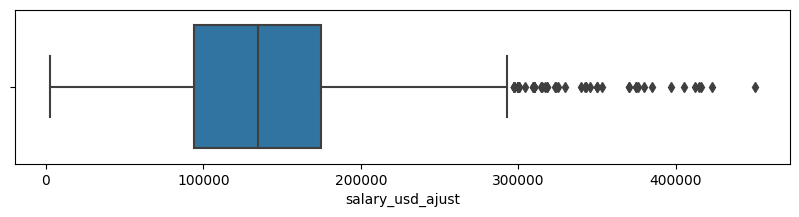

In [106]:
#Outliers

plt.figure(figsize=(10, 2))

sns.boxplot(x=df['salary_usd_ajust'])


In [107]:
# calcular valores atipicos y representacion de los mismos.

Q1 = df["salary_usd_ajust"].quantile(0.25)
Q3 = df["salary_usd_ajust"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df["salary_usd_ajust"] < lower_bound) | (df["salary_usd_ajust"] > upper_bound)]
outliers_percentage = (len(outliers) / len(df)) * 100

print(f"Total de valores atípicos: {len(outliers)}")
print(f"Porcentaje de valores atípicos: {outliers_percentage:.2f}%")

Total de valores atípicos: 62
Porcentaje de valores atípicos: 1.65%


In [108]:
# Mostramos las filas del dataframe original que son outliers
df_outliers = df[(df["salary_usd_ajust"] < lower_bound) | (df["salary_usd_ajust"] > upper_bound)]

# Ordenanamos las filas por salario en orden descendente
df_outliers_ordenado = df_outliers.sort_values(by='salary_usd_ajust', ascending=False)

# Mostramos el DataFrame ordenado
df_outliers_ordenado

,work_year,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_size,employee_residence_c,employee_continent,company_location_c,company_location_continent,salary_usd_ajust,reside_en_mismo_pais
3522,2020,Mid-level,Full-time,Research Scientist,450000,in company,M,United States of America,América,United States of America,América,450000.000,Sí
3747,2021,Mid-level,Full-time,Applied Machine Learning Scientist,423000,hibrido,L,United States of America,América,United States of America,América,423000.000,Sí
3675,2021,Executive,Contract,Principal Data Scientist,416000,remote,S,United States of America,América,United States of America,América,416000.000,Sí
528,2023,Senior,Full-time,AI Scientist,423834,in company,L,Israel,Asia,Israel,Asia,414509.652,Sí
3750,2020,Senior,Full-time,Data Scientist,412000,remote,L,United States of America,América,United States of America,América,412000.000,Sí
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2832,2022,Executive,Full-time,Data Engineer,297500,remote,M,United States of America,América,United States of America,América,297500.000,Sí
1675,2023,Senior,Full-time,Data Science Manager,297300,remote,M,United States of America,América,United States of America,América,297300.000,Sí
482,2023,Senior,Full-time,Data Scientist,297300,remote,M,United States of America,América,United States of America,América,297300.000,Sí
716,2023,Senior,Full-time,Data Scientist,297300,remote,M,United States of America,América,United States of America,América,297300.000,Sí


## Analisis de variables.

# 1. Salary

In [109]:
# describe de Salary. 

salario = df["salary_usd_ajust"]
print(salario.describe())

#Analizamos el coef de asimetria y la curtosis.

coef_asimetria = skew(salario)
print("el coeficiente de asimetria es a: ",coef_asimetria)
curtorsis = kurtosis(salario)
print("la curtosis es igual a: ",curtorsis)

count      3755.000000
mean     136805.217522
std       63445.831148
min        2769.116401
25%       94051.833047
50%      135000.000000
75%      175000.000000
max      450000.000000
Name: salary_usd_ajust, dtype: float64
el coeficiente de asimetria es a:  0.5073324174523366
la curtosis es igual a:  0.7421022453637205


In [110]:

# Prueba de normalidad
_, p_value = shapiro(df["salary_usd_ajust"])

# Imprimir el resultado
if p_value > 0.05:
    print("La distribución sigue una distribución normal")
else:
    print("La distribución no sigue una distribución normal")

La distribución no sigue una distribución normal


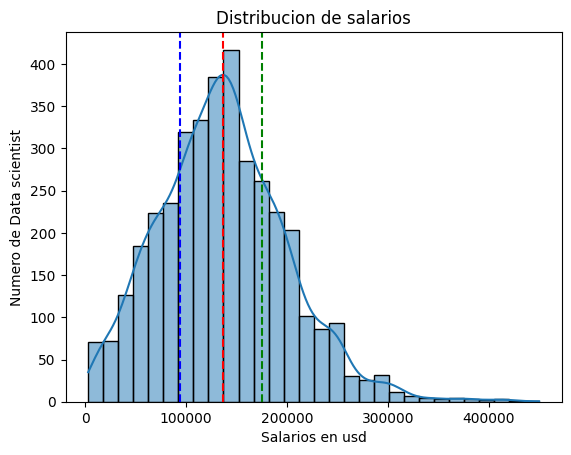

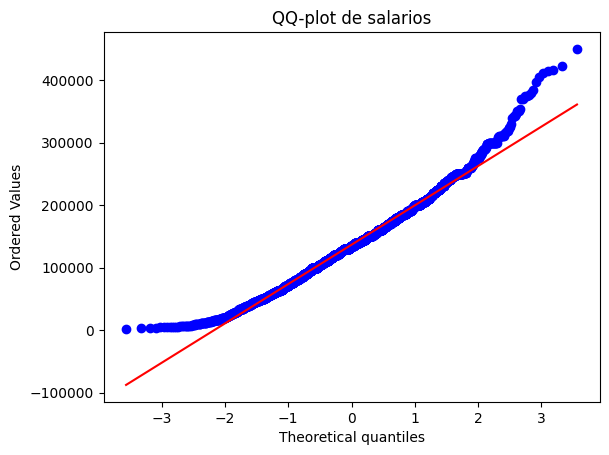

In [111]:

#Distribucion
sns.histplot(df["salary_usd_ajust"], bins=30,kde=True)
plt.title("Distribucion de salarios")
plt.xlabel("Salarios en usd")
plt.ylabel("Numero de Data scientist")


media_salario = df["salary_usd_ajust"].mean()
q1_salario = np.percentile(df["salary_usd_ajust"],25)
q3_salario = np.percentile(df["salary_usd_ajust"],75)

plt.axvline(media_salario, color='red', linestyle='--', label='Media')
plt.axvline(q1_salario, color='blue', linestyle='--', label='Q1')
plt.axvline(q3_salario, color='green', linestyle='--', label='Q3')
plt.show()


# QQ-plot
probplot(df["salary_usd_ajust"], plot=plt)
plt.title("QQ-plot de salarios")

plt.show()


   work_year  salary_usd_ajust
0       2020      92302.631579
1       2021      92922.496303
2       2022     132137.583019
3       2023     148705.590757


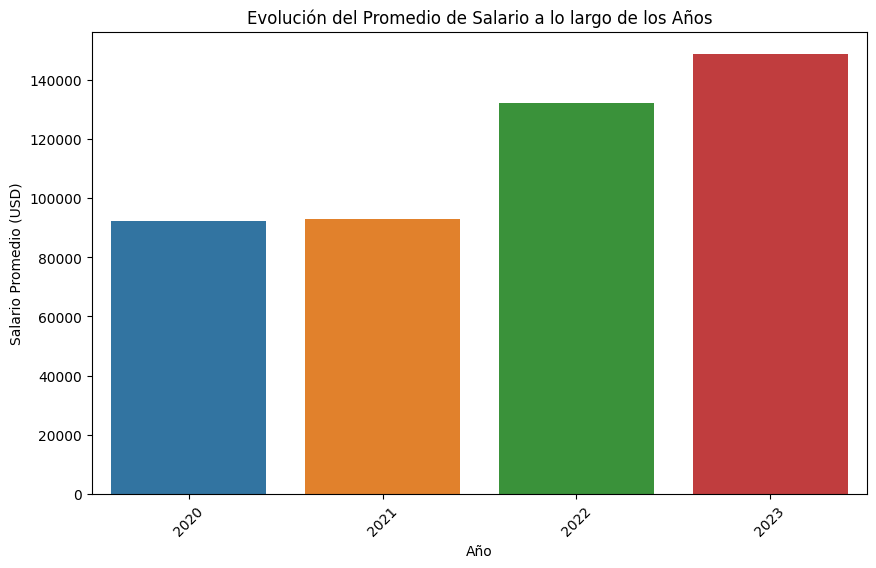

In [112]:
# Calcular el salario promedio por año
salario_promedio_por_año = df.groupby("work_year")["salary_usd_ajust"].mean().reset_index()

# Mostrar la tabla con el promedio de salario por año
print(salario_promedio_por_año)

# Gráfico de la evolución del promedio de salario por año
plt.figure(figsize=(10, 6))
sns.barplot(x="work_year", y="salary_usd_ajust", data=salario_promedio_por_año)
plt.xlabel("Año")
plt.ylabel("Salario Promedio (USD)")
plt.title("Evolución del Promedio de Salario a lo largo de los Años")
plt.xticks(rotation=45)
plt.show()



# 2. experience_lavel

Senior         2516
Mid-level       805
Entry-level     320
Executive       114
Name: experience_level, dtype: int64


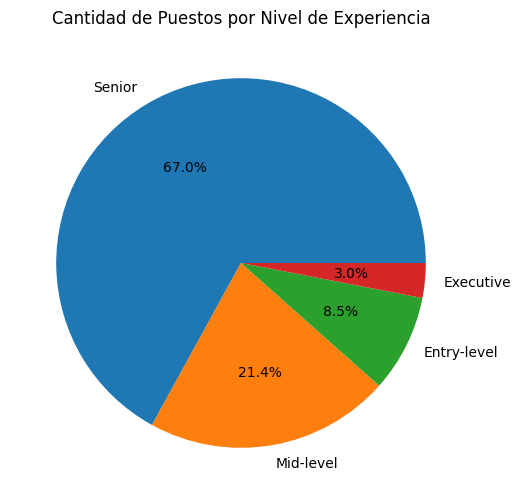

In [113]:
# Contamos la cantidad de puestos por tipo de experiencia
cantidad_por_experiencia = df['experience_level'].value_counts()
print(cantidad_por_experiencia)

# gráfico de torta
plt.figure(figsize=(8, 6))
plt.pie(cantidad_por_experiencia, labels=cantidad_por_experiencia.index,autopct='%1.1f%%')
plt.title('Cantidad de Puestos por Nivel de Experiencia')
plt.show()

In [114]:
prom_salario_experiencia = df.groupby('experience_level')['salary_usd_ajust'].mean().sort_values(ascending=False)
print(prom_salario_experiencia)

experience_level
Executive      193994.786735
Senior         152584.349190
Mid-level      103066.960621
Entry-level     77240.813265
Name: salary_usd_ajust, dtype: float64


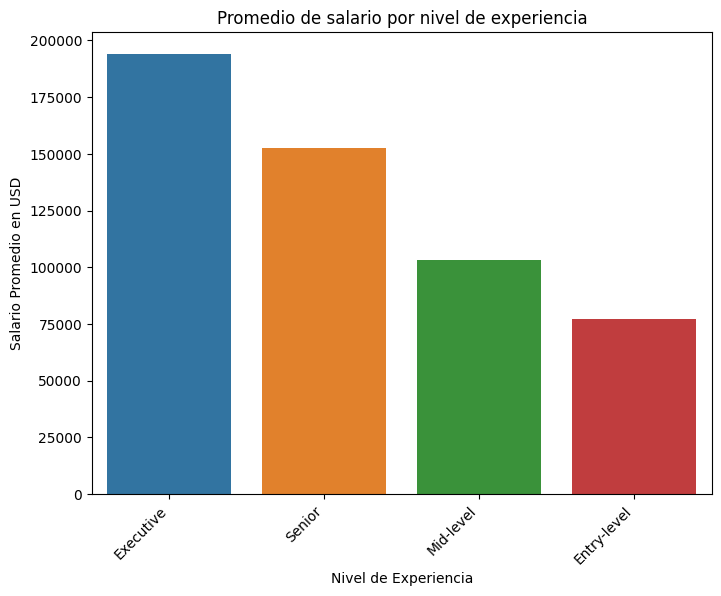

In [115]:

# gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x=prom_salario_experiencia.index, y=prom_salario_experiencia.values)
plt.title('Promedio de salario por nivel de experiencia')
plt.xlabel('Nivel de Experiencia')
plt.ylabel('Salario Promedio en USD')
plt.xticks(rotation=45, ha='right') 
plt.show()


experience_level  Entry-level  Executive  Mid-level  Senior
work_year                                                  
2020                       23          3         32      18
2021                       55         10         92      73
2022                      124         41        361    1138
2023                      118         60        320    1287


<Figure size 1000x600 with 0 Axes>

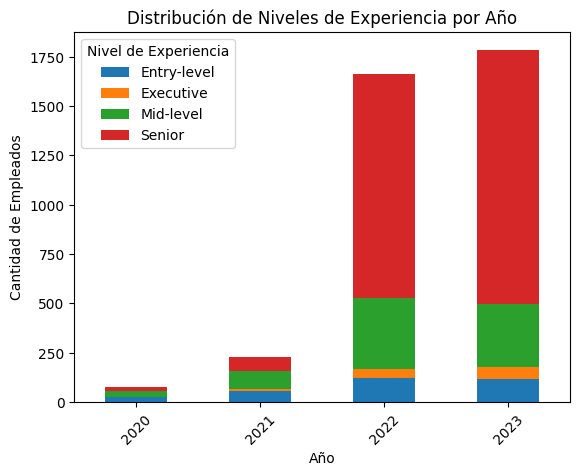

In [116]:
# Tabla de frecuencias de niveles de experiencia por año
experiencia_por_año = df.groupby(["work_year", "experience_level"]).size().unstack()

print(experiencia_por_año)

# Gráfico de barras apiladas de la distribución de niveles de experiencia por año
plt.figure(figsize=(10, 6))
experiencia_por_año.plot(kind="bar", stacked=True)
plt.xlabel("Año")
plt.ylabel("Cantidad de Empleados")
plt.title("Distribución de Niveles de Experiencia por Año")
plt.xticks(rotation=45) 
plt.legend(title='Nivel de Experiencia')
plt.show()


    work_year experience_level  salary_usd_ajust
0        2020      Entry-level      57511.608696
1        2020        Executive     139944.333333
2        2020        Mid-level      87564.718750
3        2020           Senior     137240.500000
4        2021      Entry-level      54065.109068
5        2021        Executive     182192.995463
6        2021        Mid-level      81102.438953
7        2021           Senior     124866.285105
8        2022      Entry-level      74448.027870
9        2022        Executive     186855.741542
10       2022        Mid-level      98860.985068
11       2022           Senior     147008.331877
12       2023      Entry-level      94823.362627
13       2023        Executive     203542.622167
14       2023        Mid-level     115676.850959
15       2023           Senior     159301.610780


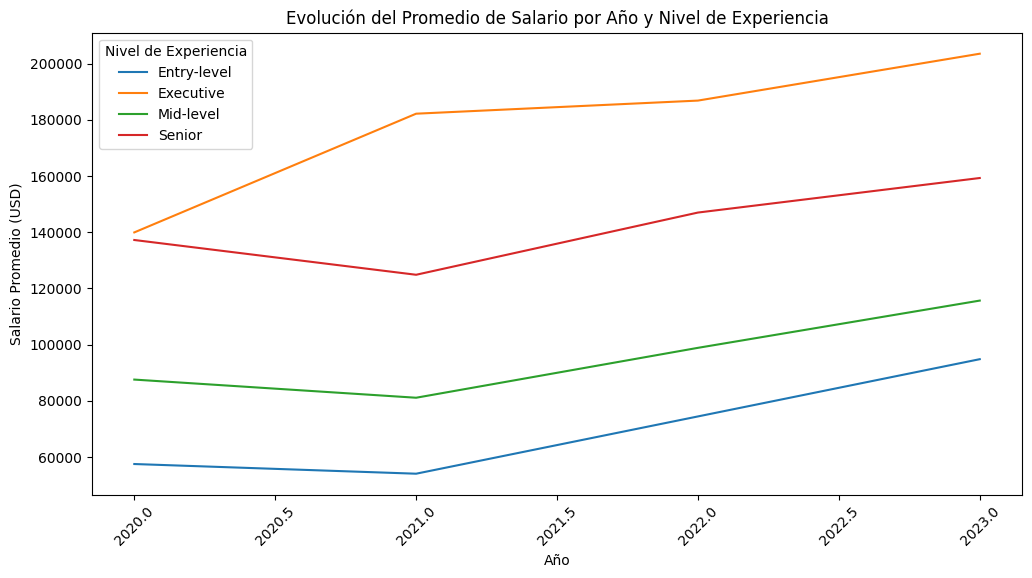

In [117]:
# Calcular el salario promedio por año y nivel de experiencia
salario_promedio_por_año_y_experiencia = df.groupby(["work_year", "experience_level"])["salary_usd_ajust"].mean().reset_index()

print(salario_promedio_por_año_y_experiencia)

# Gráfico de línea de la evolución del promedio de salario por año y nivel de experiencia
plt.figure(figsize=(12, 6))
sns.lineplot(x="work_year", y="salary_usd_ajust", hue="experience_level", data=salario_promedio_por_año_y_experiencia)
plt.xlabel("Año")
plt.ylabel("Salario Promedio (USD)")
plt.title("Evolución del Promedio de Salario por Año y Nivel de Experiencia")
plt.xticks(rotation=45) 
plt.legend(title='Nivel de Experiencia')
plt.show()

# 3. employment_type

Full-time    3718
Part-time      17
Contract       10
Freelance      10
Name: employment_type, dtype: int64


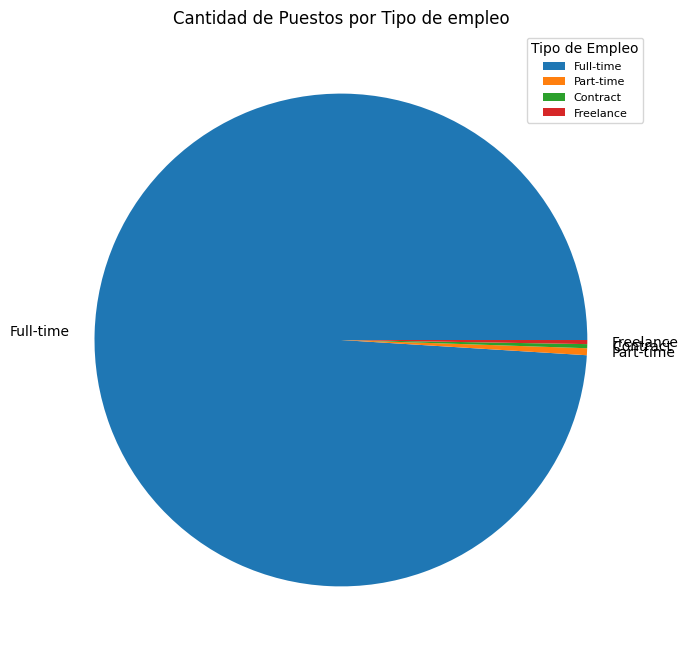

In [118]:
# Contamos la cantidad de puestos por tipo de experiencia
cantidad_por_tipo = df['employment_type'].value_counts()
print(cantidad_por_tipo)

# Creamos el gráfico de torta
plt.figure(figsize=(15, 8))
plt.pie(cantidad_por_tipo, labels=cantidad_por_tipo.index)
plt.title('Cantidad de Puestos por Tipo de empleo')
plt.legend(cantidad_por_tipo.index, title='Tipo de Empleo', loc='best', fontsize=8)
plt.show()

In [119]:
prom_salario_tipoempleo = df.groupby('employment_type')['salary_usd_ajust'].mean().sort_values(ascending=False)
print(prom_salario_tipoempleo)

employment_type
Full-time    137564.248495
Contract     112973.715603
Freelance     46019.370854
Part-time     38222.648508
Name: salary_usd_ajust, dtype: float64


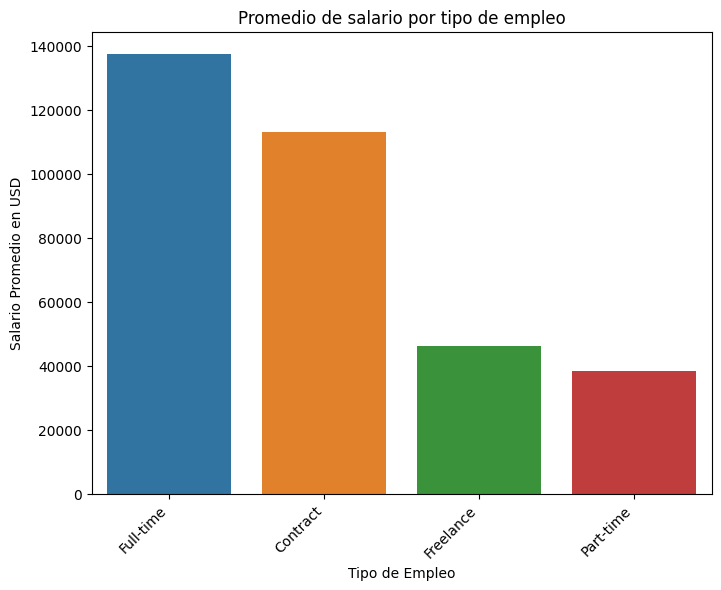

In [120]:
#gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x=prom_salario_tipoempleo.index, y=prom_salario_tipoempleo.values)
plt.title('Promedio de salario por tipo de empleo')
plt.xlabel('Tipo de Empleo')
plt.ylabel('Salario Promedio en USD')
plt.xticks(rotation=45, ha='right')
plt.show()

    work_year employment_type  salary_in_usd
0        2020        Contract  100000.000000
1        2020       Freelance   60000.000000
2        2020       Full-time   94685.625000
3        2020       Part-time   18817.500000
4        2021        Contract  263666.666667
5        2021       Freelance   25851.666667
6        2021       Full-time   94996.852535
7        2021       Part-time   22455.142857
8        2022        Contract   46992.250000
9        2022       Freelance   70130.750000
10       2022       Full-time  133988.781079
11       2022       Part-time   65639.000000
12       2023        Contract   27750.000000
13       2023       Freelance   50000.000000
14       2023       Full-time  149366.860674
15       2023       Part-time   17779.000000


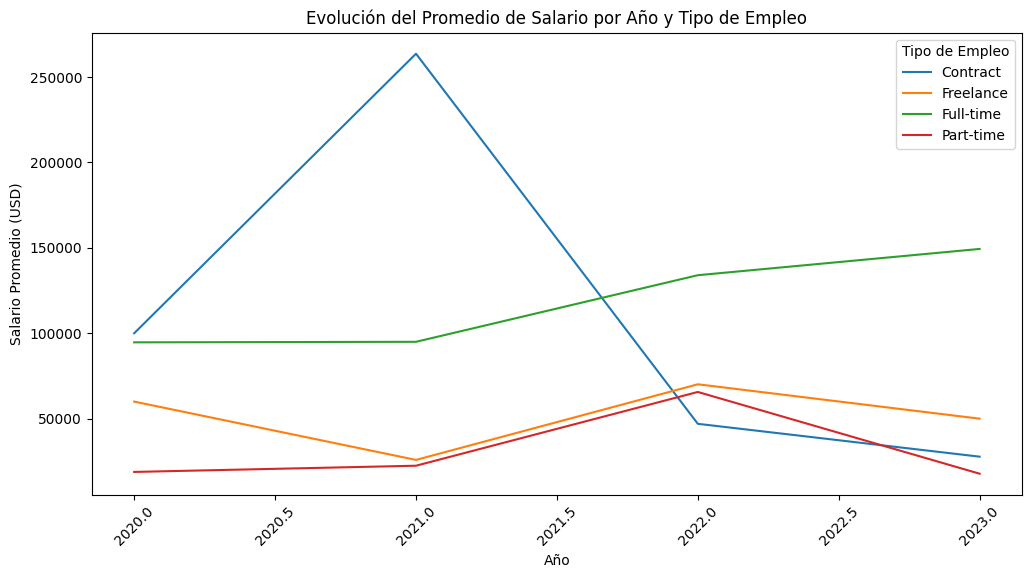

In [121]:
# Calcular el salario promedio por año y tipo de empleo
salario_promedio_por_año_y_empleo = df.groupby(["work_year", "employment_type"])["salary_in_usd"].mean().reset_index()

print(salario_promedio_por_año_y_empleo)

# Gráfico de línea de la evolución del promedio de salario por año y tipo de empleo
plt.figure(figsize=(12, 6))
sns.lineplot(x="work_year", y="salary_in_usd", hue="employment_type", data=salario_promedio_por_año_y_empleo)
plt.xlabel("Año")
plt.ylabel("Salario Promedio (USD)")
plt.title("Evolución del Promedio de Salario por Año y Tipo de Empleo")
plt.xticks(rotation=45)  
plt.legend(title='Tipo de Empleo')
plt.show()


# 4. Company_size

In [122]:
# Calculamos el promedio de salario por tamaño de empresa y la cantidad
prom_salario_tam_empresa = df.groupby('company_size')['salary_usd_ajust'].mean().sort_values(ascending=False)
cantidad_por_tamano = df['company_size'].value_counts()

# Creamos un DataFrame con la info
data_tamano = pd.DataFrame({'Promedio de Salario (USD)': prom_salario_tam_empresa,
                     'Cantidad de Puestos': cantidad_por_tamano})
print(data_tamano)


   Promedio de Salario (USD)  Cantidad de Puestos
M              142507.162100                 3153
L              116900.565580                  454
S               76389.546754                  148


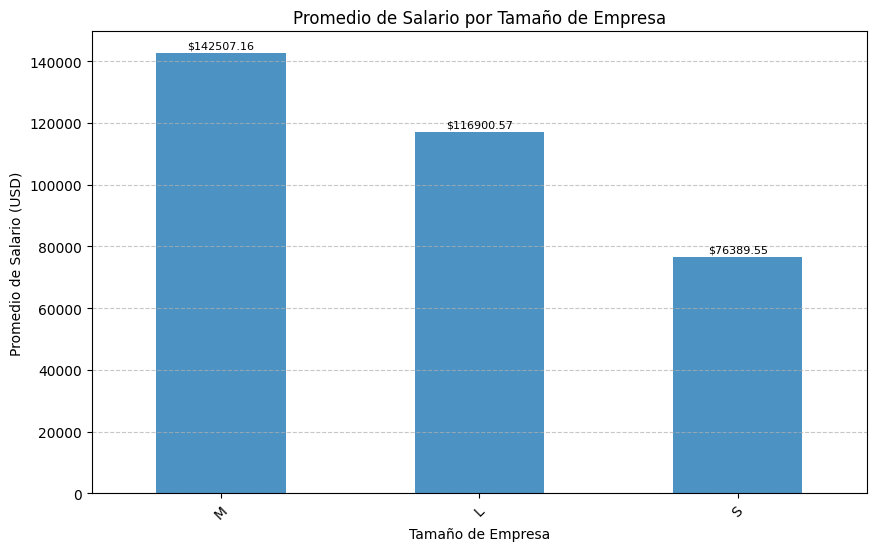

In [123]:
#gráfico de barras
plt.figure(figsize=(10, 6))
data_tamano['Promedio de Salario (USD)'].plot(kind='bar', alpha=0.8)
plt.xticks(rotation=45)
plt.xlabel('Tamaño de Empresa')
plt.ylabel('Promedio de Salario (USD)')
plt.title('Promedio de Salario por Tamaño de Empresa')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el valor numérico en la parte superior de cada barra
for index, value in enumerate(data_tamano['Promedio de Salario (USD)']):
    plt.text(index, value + 1000, f"${value:.2f}", ha='center', va='bottom', fontsize=8)

plt.show()

    work_year company_size  salary_in_usd
0        2020            L  101000.371429
1        2020            M  106626.437500
2        2020            S   70958.560000
3        2021            L  107165.700787
4        2021            M   74463.035714
5        2021            S   82129.446809
6        2022            L  121281.959391
7        2022            M  137132.464968
8        2022            S   78050.851852
9        2023            L  133379.400000
10       2023            M  150867.202038
11       2023            S   78579.772727


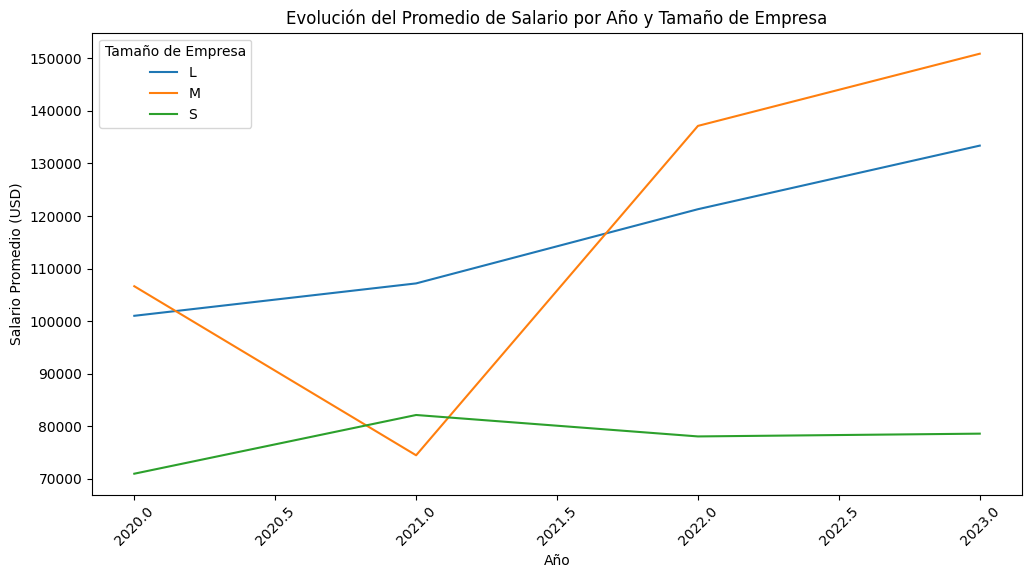

In [124]:
#Calcular el salario promedio por año y tamaño de empresa
salario_promedio_por_año_y_tamaño = df.groupby(["work_year", "company_size"])["salary_in_usd"].mean().reset_index()

print(salario_promedio_por_año_y_tamaño)

#Gráfico de línea de la evolución del promedio de salario por año y tamaño de empresa
plt.figure(figsize=(12, 6))
sns.lineplot(x="work_year", y="salary_in_usd", hue="company_size", data=salario_promedio_por_año_y_tamaño)
plt.xlabel("Año")
plt.ylabel("Salario Promedio (USD)")
plt.title("Evolución del Promedio de Salario por Año y Tamaño de Empresa")
plt.xticks(rotation=45) 
plt.legend(title='Tamaño de Empresa')
plt.show()

# 5. Company_location

In [125]:
def analisis_cantidad_y_porcentaje(df, columna):
    """
    Realiza el análisis de cantidad y porcentaje para una columna específica de un DataFrame.

    Parámetros:
        df (DataFrame): El DataFrame que contiene los datos.
        columna (str): El nombre de la columna para realizar el análisis.

    Retorna:
        data_analisis (DataFrame): DataFrame con la cantidad y porcentaje de datos para la columna dada, ordenado de manera descendente.
    """
    #cantidad de datos por valor en la columna
    cantidad_por_valor = df[columna].value_counts()

    #porcentaje de datos para cada valor en la columna
    porcentaje_por_valor = (cantidad_por_valor / len(df)) * 100

    #DataFrame con la cantidad y el porcentaje de datos para la columna dada
    data_analisis = pd.DataFrame({'cantidad_de_datos': cantidad_por_valor,
                                  'porcentaje_de_datos': porcentaje_por_valor})

    #Ordenamos el DataFrame por cantidad de datos de manera descendente
    data_analisis = data_analisis.sort_values('porcentaje_de_datos', ascending=False)

    return data_analisis

In [126]:
data_ubicacion = analisis_cantidad_y_porcentaje(df,"company_location_c")
data_ubicacion

,cantidad_de_datos,porcentaje_de_datos
United States of America,3040,80.958722
United Kingdom,172,4.580559
Canada,87,2.316911
Spain,77,2.050599
India,58,1.544607
...,...,...
New Zealand,1,0.026631
Chile,1,0.026631
Moldova,1,0.026631
Egypt,1,0.026631


          company_location_c  salary_usd_ajust
16  United States of America     151822.009539
3                     Canada     126043.492559
9                      Japan     114276.319360
8                    Ireland     109359.318088
10                    Mexico      92394.873618
5                    Germany      84887.482063
15            United Kingdom      82144.602574
0                  Australia      75444.528571
11               Netherlands      73241.880964
1                    Austria      68203.998528
4                     France      63879.473728
14                     Spain      54773.759589
13                 Singapore      51633.404043
12                  Portugal      48124.758401
6                     Greece      47431.688635
2                     Brazil      36935.448499
7                      India      28637.456276


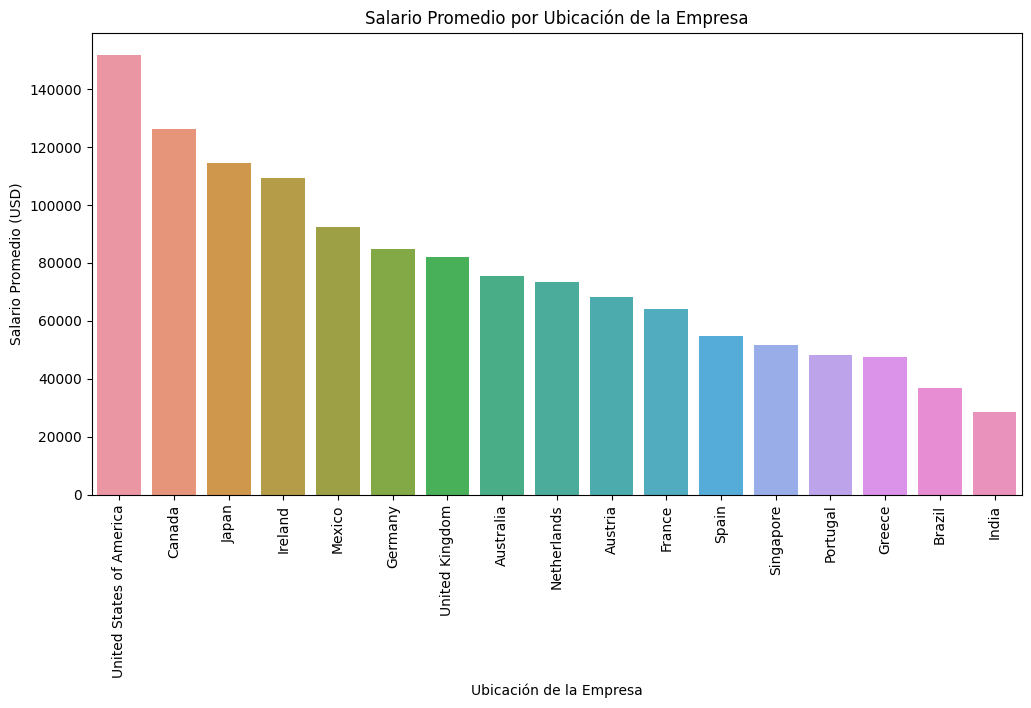

In [127]:


#titulos con una cantidad de puestos mayor a 5
ubicaciones_filtradas = data_ubicacion[data_ubicacion["cantidad_de_datos"] > 5].index

#DataFrame original por las ubicaciones seleccionadas
df_filtrado_ubi = df[df["company_location_c"].isin(ubicaciones_filtradas)]

#salario promedio por titulo solo para las titulos seleccionadas
salario_promedio_por_ubicacion = df_filtrado_ubi.groupby("company_location_c")["salary_usd_ajust"].mean().reset_index()

#titulos por salario promedio de manera descendente
salario_promedio_por_ubicacion = salario_promedio_por_ubicacion.sort_values("salary_usd_ajust", ascending=False)
(print(salario_promedio_por_ubicacion))
#gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x="company_location_c", y="salary_usd_ajust", data=salario_promedio_por_ubicacion)
plt.xlabel("Ubicación de la Empresa")
plt.ylabel("Salario Promedio (USD)")
plt.title("Salario Promedio por Ubicación de la Empresa")
plt.xticks(rotation=90)
plt.show()


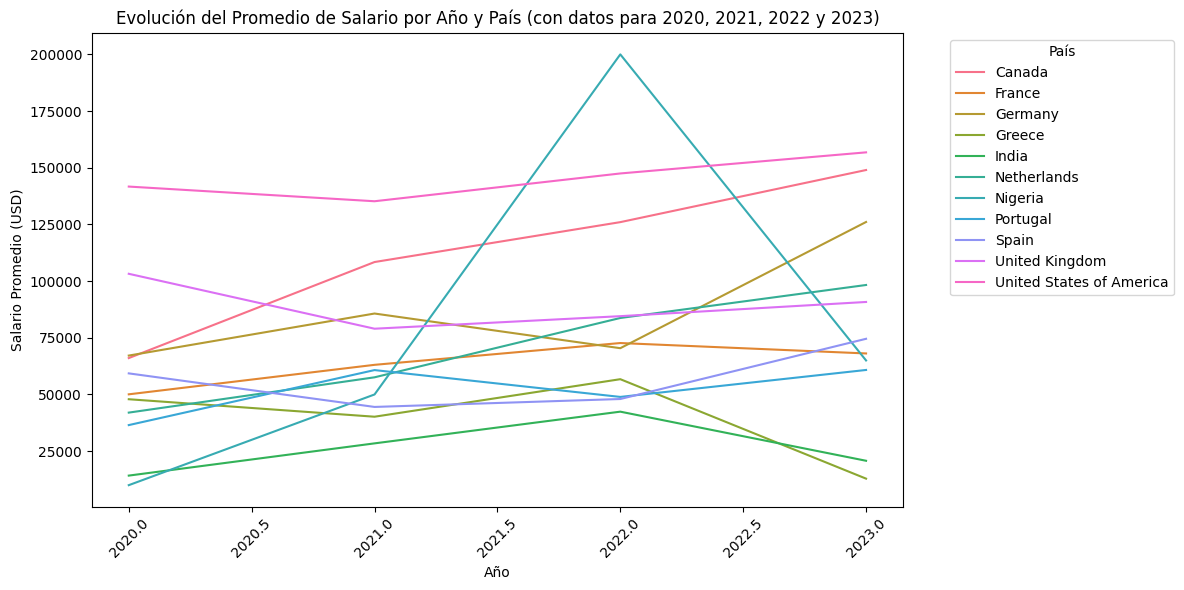

In [128]:
#Filtramos los países que tienen al menos un salario para cada año (2020, 2021, 2022 y 2023)
paises_con_salarios_completos = df.groupby("company_location_c")["work_year"].nunique() == 4
paises_filtrados = paises_con_salarios_completos[paises_con_salarios_completos].index

#Filtramos DataFrame original para incluir solo los países seleccionados
df_paises_filtrados = df[df["company_location_c"].isin(paises_filtrados)]

salario_promedio_por_pais = df_paises_filtrados.groupby(["work_year", "company_location_c"])["salary_in_usd"].mean().reset_index()

#Gráfico de línea del promedio de salario por año y país
plt.figure(figsize=(12, 6))
sns.lineplot(x="work_year", y="salary_in_usd", hue="company_location_c", data=salario_promedio_por_pais)
plt.xlabel("Año")
plt.ylabel("Salario Promedio (USD)")
plt.title("Evolución del Promedio de Salario por Año y País (con datos para 2020, 2021, 2022 y 2023)")
plt.xticks(rotation=45)
plt.legend(title='País', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [129]:
#Utilizamos una pivot_table para mostrar el DataFrame agrupado por país y años
tabla_pivot = salario_promedio_por_pais.pivot_table(index='company_location_c', columns='work_year', values='salary_in_usd')

#Ordenamos el DataFrame por salario promedio del año 2020 al 2023
tabla_pivot = tabla_pivot[[2020, 2021, 2022, 2023]]

#calculamos la diferencia entre los años 2020 y 2021, 2021 y 2022, y 2022 y 2023
tabla_pivot['2020-2021'] = tabla_pivot[2021] - tabla_pivot[2020]
tabla_pivot['2021-2022'] = tabla_pivot[2022] - tabla_pivot[2021]
tabla_pivot['2022-2023'] = tabla_pivot[2023] - tabla_pivot[2022]

#Ordenamos el DataFrame por salario promedio del año 2020 al 2023
tabla_pivot = tabla_pivot[[2020, 2021, 2022, 2023, '2020-2021', '2021-2022', '2022-2023']]

tabla_pivot

work_year,2020,2021,2022,2023,2020-2021,2021-2022,2022-2023
company_location_c,,,,,,,
Canada,66052.000000,108410.545455,126009.552632,148996.000000,42358.545455,17599.007177,22986.447368
France,50066.400000,63072.666667,72684.466667,68092.800000,13006.266667,9611.800000,-4591.666667
Germany,67157.000000,85700.812500,70410.842105,126075.357143,18543.812500,-15289.970395,55664.515038
Greece,47899.000000,40189.000000,56739.090909,12877.000000,-7710.000000,16550.090909,-43862.090909
India,14219.666667,28433.500000,42417.650000,20760.666667,14213.833333,13984.150000,-21656.983333
Netherlands,42000.000000,57566.000000,83736.000000,98289.000000,15566.000000,26170.000000,14553.000000
Nigeria,10000.000000,50000.000000,200000.000000,65000.000000,40000.000000,150000.000000,-135000.000000
Portugal,36494.500000,60757.000000,48921.375000,60808.333333,24262.500000,-11835.625000,11886.958333
Spain,59304.500000,44501.833333,47997.341463,74555.214286,-14802.666667,3495.508130,26557.872822


# 6. Job_title

In [130]:

data_titulo = analisis_cantidad_y_porcentaje(df,"job_title")
print(data_titulo)

                           cantidad_de_datos  porcentaje_de_datos
Data Engineer                           1040            27.696405
Data Scientist                           840            22.370173
Data Analyst                             612            16.298269
Machine Learning Engineer                289             7.696405
Analytics Engineer                       103             2.743009
...                                      ...                  ...
Data DevOps Engineer                       1             0.026631
Cloud Data Architect                       1             0.026631
Head of Machine Learning                   1             0.026631
Principal Data Architect                   1             0.026631
Finance Data Analyst                       1             0.026631

[93 rows x 2 columns]


                        job_title  salary_usd_ajust
46         Data Science Tech Lead     375000.000000
19           Cloud Data Architect     250000.000000
35                      Data Lead     212500.000000
28            Data Analytics Lead     210860.547500
84       Principal Data Scientist     195911.648278
..                            ...               ...
9   Autonomous Vehicle Technician      25812.000000
0   3D Computer Vision Researcher      19923.723375
91             Staff Data Analyst      15000.000000
87         Product Data Scientist       7510.315197
80             Power BI Developer       5131.442170

[93 rows x 2 columns]


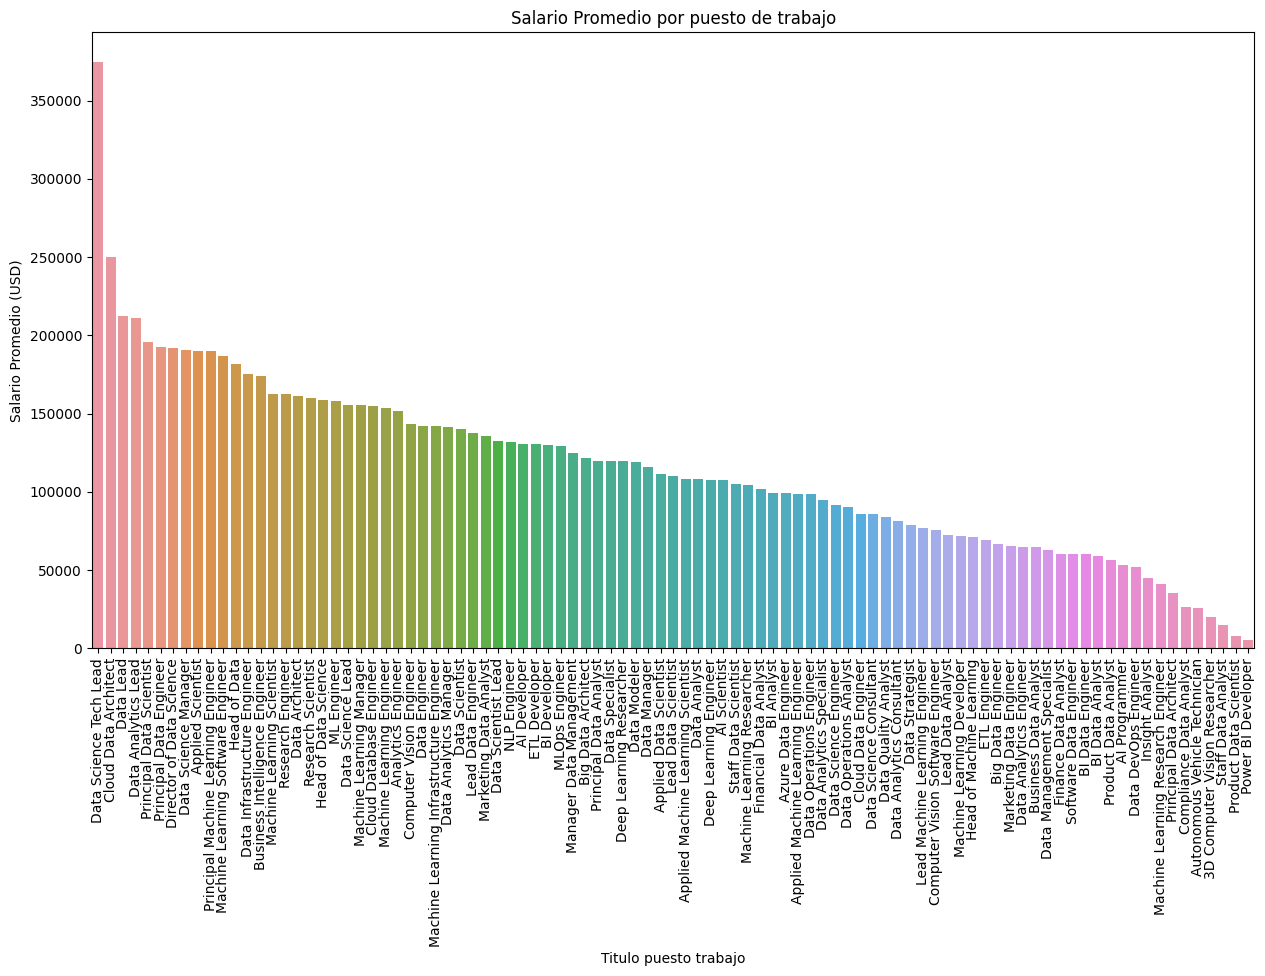

In [131]:
#salario promedio por titulo
salario_promedio_por_jt = df.groupby("job_title")["salary_usd_ajust"].mean().reset_index()


salario_promedio_por_jt = salario_promedio_por_jt.sort_values("salary_usd_ajust", ascending=False)
print(salario_promedio_por_jt)

#gráfico de barras
plt.figure(figsize=(15, 8))
sns.barplot(x="job_title", y="salary_usd_ajust", data=salario_promedio_por_jt)
plt.xlabel("Titulo puesto trabajo")
plt.ylabel("Salario Promedio (USD)")
plt.title("Salario Promedio por puesto de trabajo")
plt.xticks(rotation=90) 
plt.show()

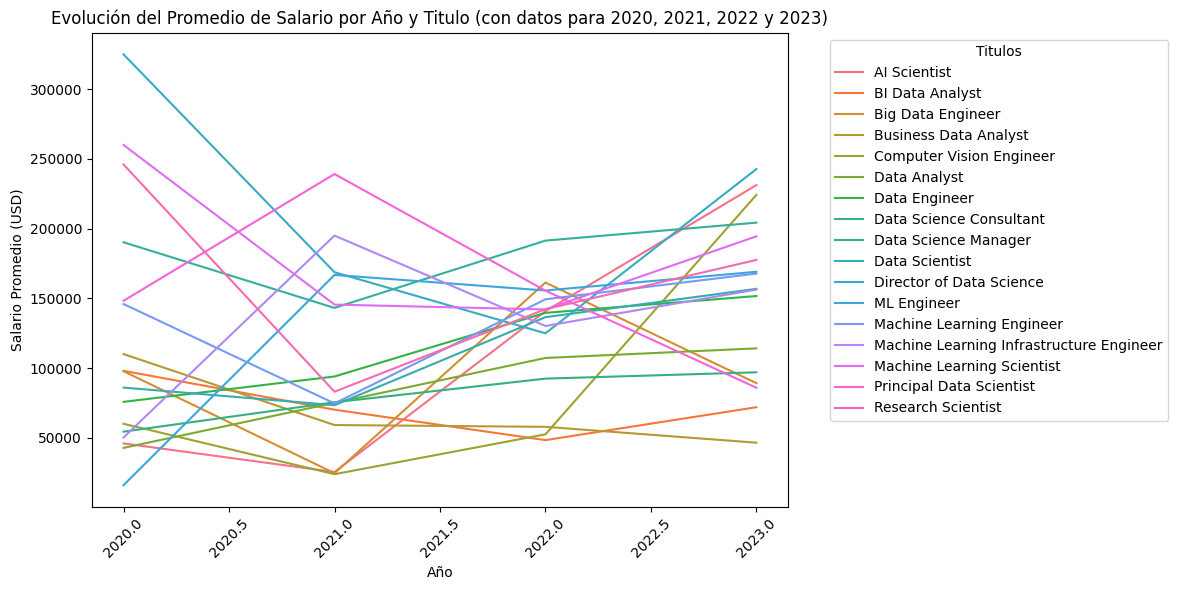

In [132]:
#Filtramos los titulos que tienen al menos un salario para cada año (2020, 2021, 2022 y 2023)
titulos_con_salarios_completos = df.groupby("job_title")["work_year"].nunique() == 4
titulos_filtrados = titulos_con_salarios_completos[titulos_con_salarios_completos].index


#Filtramos elDataFrame original para incluir solo los titulos seleccionados
df_titulos_filtrados = df[df["job_title"].isin(titulos_filtrados)]
#salario promedio por año y titulo
salario_promedio_por_titulo = df_titulos_filtrados.groupby(["work_year", "job_title"])["salary_in_usd"].mean().reset_index()


#Gráfico de línea del promedio de salario por año y titulo
plt.figure(figsize=(12, 6))
sns.lineplot(x="work_year", y="salary_in_usd", hue="job_title", data=salario_promedio_por_titulo)
plt.xlabel("Año")
plt.ylabel("Salario Promedio (USD)")
plt.title("Evolución del Promedio de Salario por Año y Titulo (con datos para 2020, 2021, 2022 y 2023)")
plt.xticks(rotation=45)
plt.legend(title='Titulos', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [133]:
#pivot_table para mostrar el DataFrame agrupado por titulo y años
tabla_pivot = salario_promedio_por_titulo.pivot_table(index='job_title', columns='work_year', values='salary_in_usd')

tabla_pivot = tabla_pivot[[2020, 2021, 2022, 2023]]

tabla_pivot['2020-2021'] = tabla_pivot[2021] - tabla_pivot[2020]
tabla_pivot['2021-2022'] = tabla_pivot[2022] - tabla_pivot[2021]
tabla_pivot['2022-2023'] = tabla_pivot[2023] - tabla_pivot[2022]

tabla_pivot = tabla_pivot[[2020, 2021, 2022, 2023, '2020-2021', '2021-2022', '2022-2023']]

tabla_pivot



work_year,2020,2021,2022,2023,2020-2021,2021-2022,2022-2023
job_title,,,,,,,
AI Scientist,45896.000000,25410.600000,140815.000000,231232.500000,-20485.400000,115404.400000,90417.500000
BI Data Analyst,98000.000000,70106.200000,48271.750000,71897.000000,-27893.800000,-21834.450000,23625.250000
Big Data Engineer,97690.333333,24544.200000,161311.000000,89144.500000,-73146.133333,136766.800000,-72166.500000
Business Data Analyst,110000.000000,59102.000000,57817.625000,46446.000000,-50898.000000,-1284.375000,-11371.625000
Computer Vision Engineer,60000.000000,23838.666667,52433.500000,224240.000000,-36161.333333,28594.833333,171806.500000
Data Analyst,42705.000000,75024.952381,107207.398551,114097.475570,32319.952381,32182.446170,6890.077019
Data Engineer,75726.933333,93931.500000,139589.889344,151647.288577,18204.566667,45658.389344,12057.399233
Data Science Consultant,54353.500000,75447.600000,92388.400000,96921.857143,21094.100000,16940.800000,4533.457143
Data Science Manager,190200.000000,143126.500000,191407.206897,204290.954545,-47073.500000,48280.706897,12883.747649


# 7. Remote_ratio 

In [134]:
data_ratio = analisis_cantidad_y_porcentaje(df,"remote_ratio")
data_ratio

,cantidad_de_datos,porcentaje_de_datos
in company,1923,51.211718
remote,1643,43.754993
hibrido,189,5.033289


In [135]:
prom_salario_remote = df.groupby('remote_ratio')['salary_usd_ajust'].mean().sort_values(ascending=False)
print(prom_salario_remote)

remote_ratio
in company    143744.759972
remote        135643.132880
hibrido        76300.270082
Name: salary_usd_ajust, dtype: float64


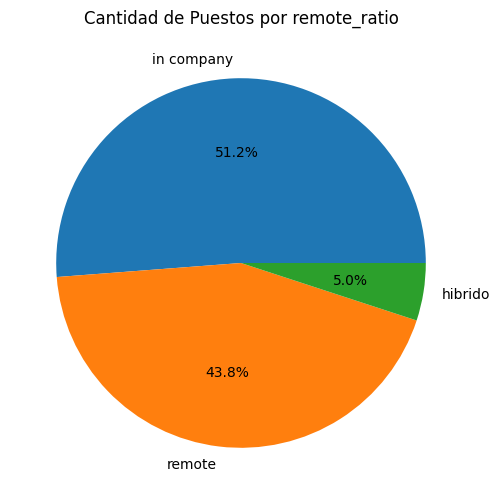

In [136]:

#gráfico de torta
plt.figure(figsize=(8, 6))
plt.pie(data_ratio["cantidad_de_datos"], labels=data_ratio.index,autopct='%1.1f%%')
plt.title('Cantidad de Puestos por remote_ratio')
plt.show()

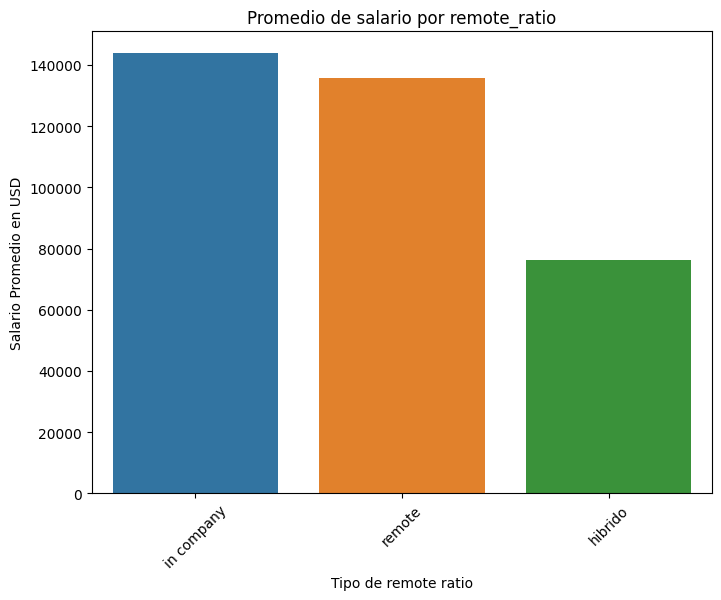

In [137]:
#gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x=prom_salario_remote.index, y=prom_salario_remote.values)
plt.title('Promedio de salario por remote_ratio')
plt.xlabel('Tipo de remote ratio')
plt.ylabel('Salario Promedio en USD')
plt.xticks(rotation=45)
plt.show()

remote_ratio  hibrido  in company  remote
work_year                                
2020               21          16      39
2021               76          34     120
2022               62         711     891
2023               30        1162     593


<Figure size 1000x600 with 0 Axes>

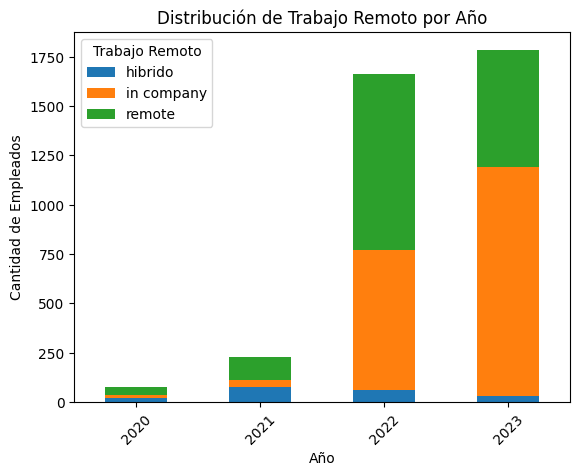

In [138]:
#Tabla de frecuencias de trabajo remoto por año
trabajo_remoto_por_año = df.groupby(["work_year", "remote_ratio"]).size().unstack()

print(trabajo_remoto_por_año)

#Gráfico de barras de la distribución de trabajo remoto por año
plt.figure(figsize=(10, 6))
trabajo_remoto_por_año.plot(kind="bar", stacked=True)
plt.xlabel("Año")
plt.ylabel("Cantidad de Empleados")
plt.title("Distribución de Trabajo Remoto por Año")
plt.xticks(rotation=45)  
plt.legend(title='Trabajo Remoto')
plt.show()

remote_ratio    hibrido  in company     remote
work_year                                     
2020          27.631579   21.052632  51.315789
2021          33.043478   14.782609  52.173913
2022           3.725962   42.728365  53.545673
2023           1.680672   65.098039  33.221289


<Figure size 1000x600 with 0 Axes>

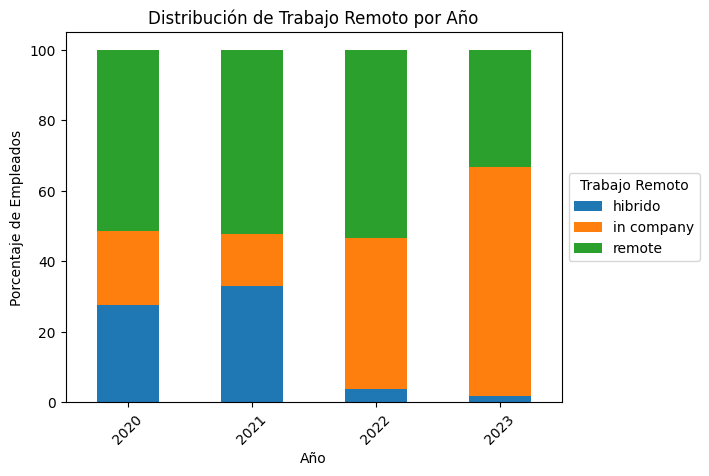

In [139]:
trabajo_remoto_por_año = df.groupby(["work_year", "remote_ratio"]).size().unstack()

trabajo_remoto_por_año_porcentaje = trabajo_remoto_por_año.apply(lambda row: row / row.sum() * 100, axis=1)

print(trabajo_remoto_por_año_porcentaje)

plt.figure(figsize=(10, 6))
trabajo_remoto_por_año_porcentaje.plot(kind="bar", stacked=True)
plt.xlabel("Año")
plt.ylabel("Porcentaje de Empleados")
plt.title("Distribución de Trabajo Remoto por Año")
plt.xticks(rotation=45) 
plt.legend(title='Trabajo Remoto', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


    work_year remote_ratio  salary_in_usd
0        2020      hibrido   77591.238095
1        2020   in company   93426.187500
2        2020       remote   99763.205128
3        2021      hibrido   76104.407895
4        2021   in company   92899.676471
5        2021       remote  105812.783333
6        2022      hibrido   84560.870968
7        2022   in company  134719.236287
8        2022       remote  135631.104377
9        2023      hibrido   72053.500000
10       2023   in company  152393.521515
11       2023       remote  146380.124789


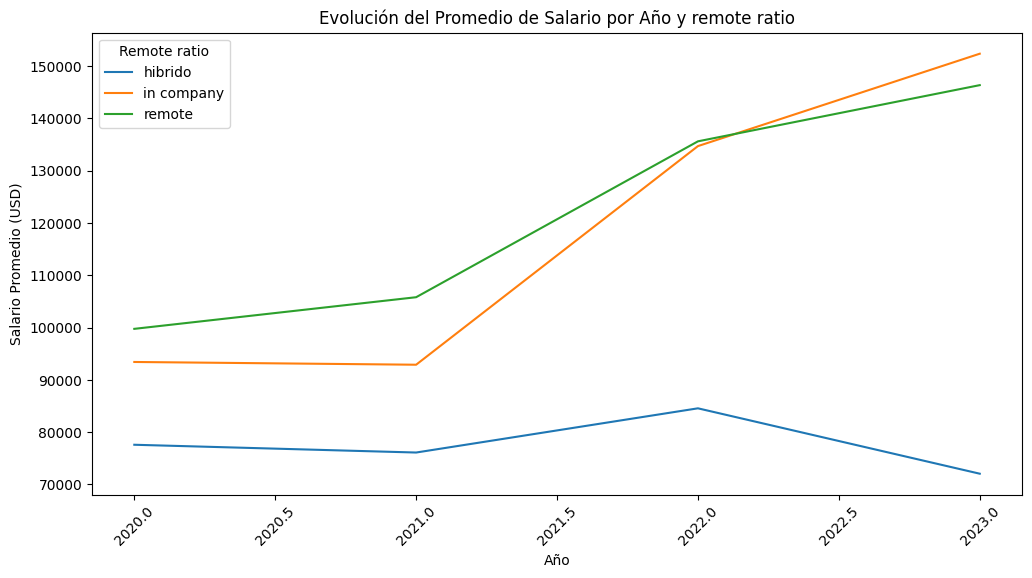

In [140]:
#Calculamos el salario promedio por año y remote
salario_promedio_por_año_y_rr = df.groupby(["work_year", "remote_ratio"])["salary_in_usd"].mean().reset_index()

print(salario_promedio_por_año_y_rr)

#Gráfico de línea de la evolución del promedio de salario por año y remote
plt.figure(figsize=(12, 6))
sns.lineplot(x="work_year", y="salary_in_usd", hue="remote_ratio", data=salario_promedio_por_año_y_rr)
plt.xlabel("Año")
plt.ylabel("Salario Promedio (USD)")
plt.title("Evolución del Promedio de Salario por Año y remote ratio")
plt.xticks(rotation=45)  
plt.legend(title='Remote ratio')
plt.show()

# 8 Employee_residence

In [141]:
data_residencia = analisis_cantidad_y_porcentaje(df, "employee_residence_c")
print(data_residencia)

                          cantidad_de_datos  porcentaje_de_datos
United States of America               3004            80.000000
United Kingdom                          167             4.447403
Canada                                   85             2.263648
Spain                                    80             2.130493
India                                    71             1.890812
...                                     ...                  ...
Malaysia                                  1             0.026631
Jersey                                    1             0.026631
New Zealand                               1             0.026631
Algeria                                   1             0.026631
Malta                                     1             0.026631

[78 rows x 2 columns]


        employee_residence_c  salary_usd_ajust
20  United States of America     152812.362813
4                     Canada     126331.160705
9                    Ireland     109359.318088
11                     Japan     103472.348101
6                    Germany      91294.048455
12                    Mexico      88068.650190
19            United Kingdom      82197.299705
1                  Australia      72981.983342
13               Netherlands      72449.541858
2                    Austria      67937.933695
5                     France      59307.154474
18                     Spain      57604.616258
14                   Nigeria      56018.457367
7                     Greece      51217.677625
17                  Portugal      50999.350397
10                     Italy      48196.463218
3                     Brazil      45890.651527
16                    Poland      44917.799602
8                      India      34765.922926
15                  Pakistan      28501.855591
0            

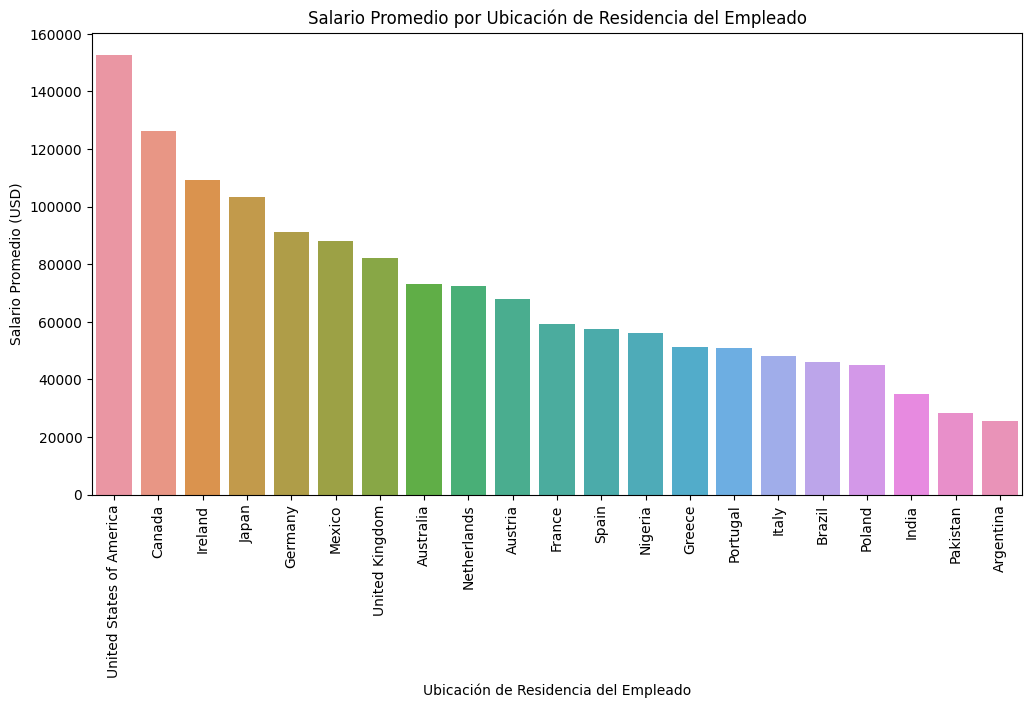

In [142]:


# Filtramos las ubicaciones de residencia con una cantidad de empleados mayor a 5
residencias_filtradas = data_residencia[data_residencia["cantidad_de_datos"] > 5].index

# Filtramos el DataFrame original por las ubicaciones de residencia seleccionadas
df_filtrado = df[df["employee_residence_c"].isin(residencias_filtradas)]

# Calculamos el salario promedio por ubicación de residencia solo para las ubicaciones seleccionadas
salario_promedio_por_residencia = df_filtrado.groupby("employee_residence_c")["salary_usd_ajust"].mean().reset_index()

# Ordenar las ubicaciones de residencia por salario promedio de manera descendente
salario_promedio_por_residencia = salario_promedio_por_residencia.sort_values("salary_usd_ajust", ascending=False)

print(salario_promedio_por_residencia)

#gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x="employee_residence_c", y="salary_usd_ajust", data=salario_promedio_por_residencia)
plt.xlabel("Ubicación de Residencia del Empleado")
plt.ylabel("Salario Promedio (USD)")
plt.title("Salario Promedio por Ubicación de Residencia del Empleado")
plt.xticks(rotation=90)
plt.show()


## 5. Otros analisis de variables.

In [143]:
groupo_exp_ratio = df.groupby(['experience_level', 'remote_ratio'])['salary_usd_ajust'].mean()
print(groupo_exp_ratio)

experience_level  remote_ratio
Entry-level       hibrido          62190.698528
                  in company      104304.170460
                  remote           63172.929995
Executive         hibrido         131341.753748
                  in company      181671.028226
                  remote          214495.722782
Mid-level         hibrido          72239.667292
                  in company      115401.493155
                  remote           95296.049645
Senior            hibrido          96467.494072
                  in company      153655.030614
                  remote          153495.333802
Name: salary_usd_ajust, dtype: float64


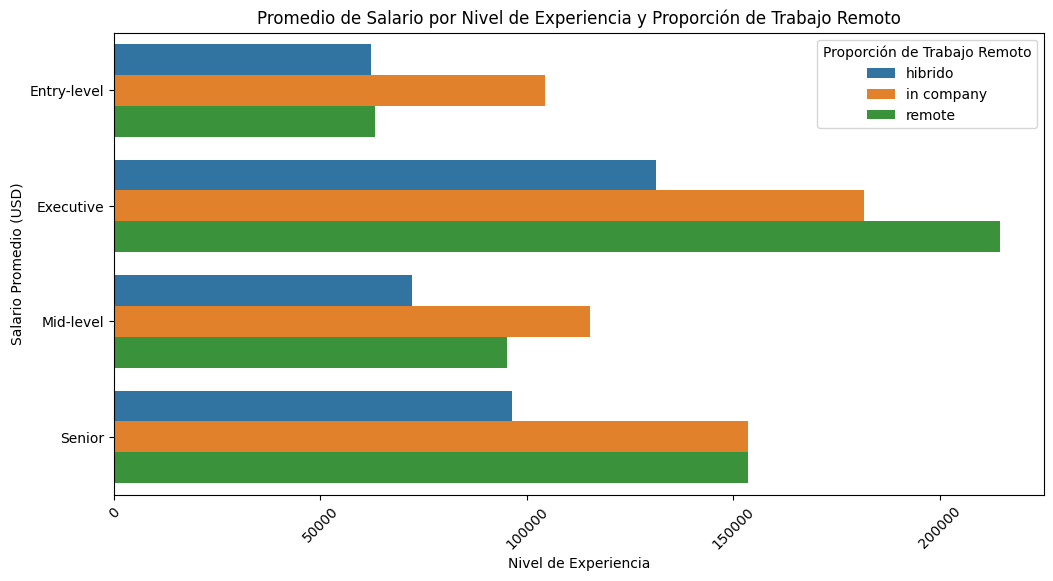

In [144]:
# Convertir el resultado del groupby en un DataFrame
groupo_exp_ratio = groupo_exp_ratio.reset_index()

# Gráfico de barras apiladas
plt.figure(figsize=(12, 6))
sns.barplot(y='experience_level', x='salary_usd_ajust', hue='remote_ratio', data=groupo_exp_ratio)
plt.xlabel('Nivel de Experiencia')
plt.ylabel('Salario Promedio (USD)')
plt.title('Promedio de Salario por Nivel de Experiencia y Proporción de Trabajo Remoto')
plt.xticks(rotation=45)
plt.legend(title='Proporción de Trabajo Remoto')
plt.show()


  company_size remote_ratio  salary_usd_ajust
0            L      hibrido      86623.092854
1            L   in company     147189.588017
2            L       remote     114967.307478
3            M      hibrido      57164.524806
4            M   in company     144391.819500
5            M       remote     143008.454687
6            S      hibrido      68921.192682
7            S   in company      80743.068800
8            S       remote      77819.758613


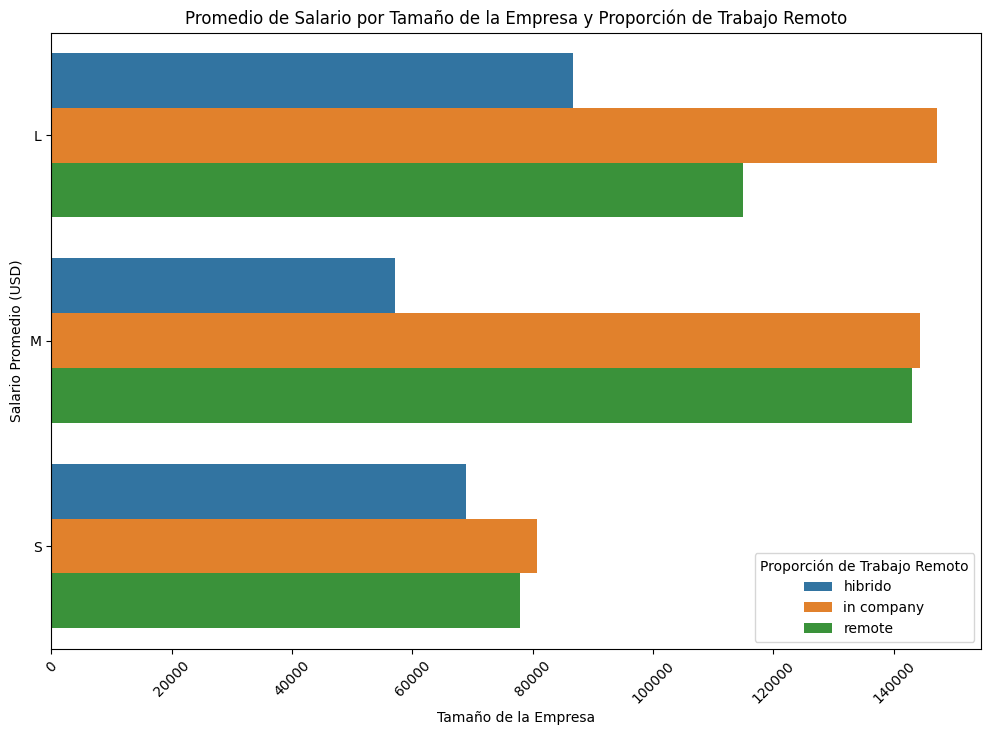

In [145]:
groupo_company_size_remote = df.groupby(['company_size', 'remote_ratio'])['salary_usd_ajust'].mean().reset_index()
print(groupo_company_size_remote)

plt.figure(figsize=(12, 8))
sns.barplot(y='company_size', x='salary_usd_ajust', hue='remote_ratio', data=groupo_company_size_remote)
plt.xlabel('Tamaño de la Empresa')
plt.ylabel('Salario Promedio (USD)')
plt.title('Promedio de Salario por Tamaño de la Empresa y Proporción de Trabajo Remoto')
plt.xticks(rotation=45)
plt.legend(title='Proporción de Trabajo Remoto')
plt.show()


   company_size experience_level  salary_usd_ajust
0             L      Entry-level      71023.272558
1             L        Executive     159419.816832
2             L        Mid-level      87889.096378
3             L           Senior     155173.589294
4             M      Entry-level      86440.762064
5             M        Executive     198652.427115
6             M        Mid-level     110098.141241
7             M           Senior     153266.013020
8             S      Entry-level      57823.728080
9             S        Executive     195161.248849
10            S        Mid-level      56416.373491
11            S           Senior     104197.769212


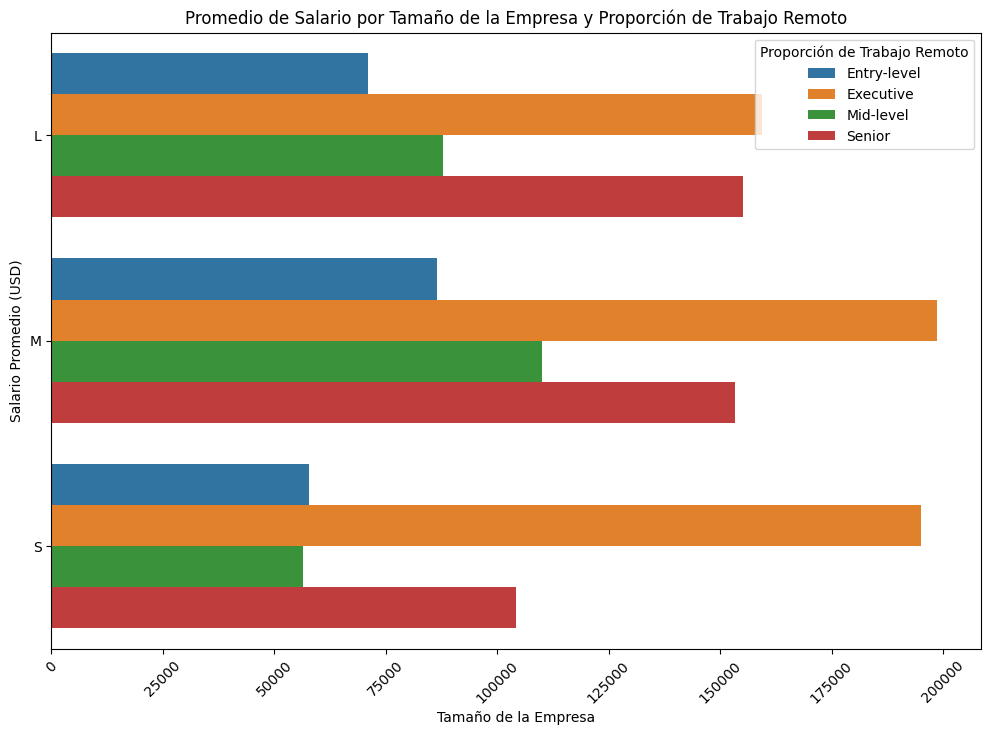

In [146]:
groupo_company_size_remote = df.groupby(['company_size', 'experience_level'])['salary_usd_ajust'].mean().reset_index()
print(groupo_company_size_remote)

plt.figure(figsize=(12, 8))
sns.barplot(y='company_size', x='salary_usd_ajust', hue='experience_level', data=groupo_company_size_remote)
plt.xlabel('Tamaño de la Empresa')
plt.ylabel('Salario Promedio (USD)')
plt.title('Promedio de Salario por Tamaño de la Empresa y Proporción de Trabajo Remoto')
plt.xticks(rotation=45)
plt.legend(title='Proporción de Trabajo Remoto')
plt.show()


## 6. Correlaciones

In [147]:

# Se define una lista de columnas numéricas (num_cols) y una lista de columnas categóricas (cat_cols) que se quieren transformar.

num_cols = ['work_year', 'salary_usd_ajust']
cat_cols = ['experience_level', 'employment_type', 'job_title', 'employee_residence_c', 'company_location_c', 'company_size', 'remote_ratio']

encoder = OrdinalEncoder()
cat_cols_en = encoder.fit_transform(df[cat_cols])
cat_cols_en = pd.DataFrame(data=cat_cols_en, columns=cat_cols)
nuevo_df = df[num_cols].join(cat_cols_en)
nuevo_df.head()

,work_year,salary_usd_ajust,experience_level,employment_type,job_title,employee_residence_c,company_location_c,company_size,remote_ratio
0,2023,83786.672,3.0,2.0,84.0,66.0,62.0,0.0,2.0
1,2023,30000.000,2.0,0.0,66.0,75.0,70.0,2.0,2.0
2,2023,25500.000,2.0,0.0,66.0,75.0,70.0,2.0,2.0
3,2023,170275.000,3.0,2.0,47.0,11.0,12.0,1.0,2.0
4,2023,116760.000,3.0,2.0,47.0,11.0,12.0,1.0,2.0


In [148]:
corr_matrix = nuevo_df.corr(method='spearman')
corr_matrix


,work_year,salary_usd_ajust,experience_level,employment_type,job_title,employee_residence_c,company_location_c,company_size,remote_ratio
work_year,1.000000,0.214295,0.158267,-0.010722,-0.022782,0.253402,0.237393,0.142470,-0.122469
salary_usd_ajust,0.214295,1.000000,0.378169,-0.008488,0.149203,0.506301,0.497041,0.017086,0.047660
experience_level,0.158267,0.378169,1.000000,-0.034185,0.025370,0.322788,0.312936,0.072653,0.063739
employment_type,-0.010722,-0.008488,-0.034185,1.000000,-0.044955,-0.025995,-0.024667,-0.035615,-0.027795
job_title,-0.022782,0.149203,0.025370,-0.044955,1.000000,-0.072470,-0.081129,-0.010304,-0.059490
employee_residence_c,0.253402,0.506301,0.322788,-0.025995,-0.072470,1.000000,0.952139,0.059659,0.068753
company_location_c,0.237393,0.497041,0.312936,-0.024667,-0.081129,0.952139,1.000000,0.078840,0.082396
company_size,0.142470,0.017086,0.072653,-0.035615,-0.010304,0.059659,0.078840,1.000000,0.052993
remote_ratio,-0.122469,0.047660,0.063739,-0.027795,-0.059490,0.068753,0.082396,0.052993,1.000000


In [149]:

# Obtener las coordenadas de las correlaciones mayores a 0.81 y diferentes a 1
filas, columnas = np.where((corr_matrix > 0.81) & (corr_matrix < 1))

# Verificar si existen correlaciones mayores a 0.81 y diferentes a 1
if len(filas) > 0:
    for fila, columna in zip(filas, columnas):
        # Imprimir los pares de fila y columna con correlación mayor a 0.81 y diferente a 1
        print("Fila:", corr_matrix.index[fila], "- Columna:", corr_matrix.columns[columna])
else:
    print("No existen correlaciones mayores a 0.81 y diferentes a 1.")


Fila: employee_residence_c - Columna: company_location_c
Fila: company_location_c - Columna: employee_residence_c


In [150]:

# Seleccionamos las dos columnas específicas que queremos correlacionar
variables_a = df['employee_residence_c']
variables_b = df['company_location_c']

# Calculamos el coeficiente de correlación de Spearman y el valor p
correlation, p_value = spearmanr(variables_a, variables_b)

# Imprimimos el coeficiente de correlación y el valor p
print("Coeficiente de correlación de Spearman:", correlation)
print("Valor p:", p_value)

# Verificamos si la correlación es estadísticamente significativa
if p_value < 0.05:
    print("La correlación es estadísticamente significativa.")
else:
    print("No hay suficiente evidencia para afirmar que la correlación es significativa.")


Coeficiente de correlación de Spearman: 0.9521385973056874
Valor p: 0.0
La correlación es estadísticamente significativa.


In [151]:
analisis_cantidad_y_porcentaje(df,"reside_en_mismo_pais")


,cantidad_de_datos,porcentaje_de_datos
Sí,3659,97.443409
No,96,2.556591


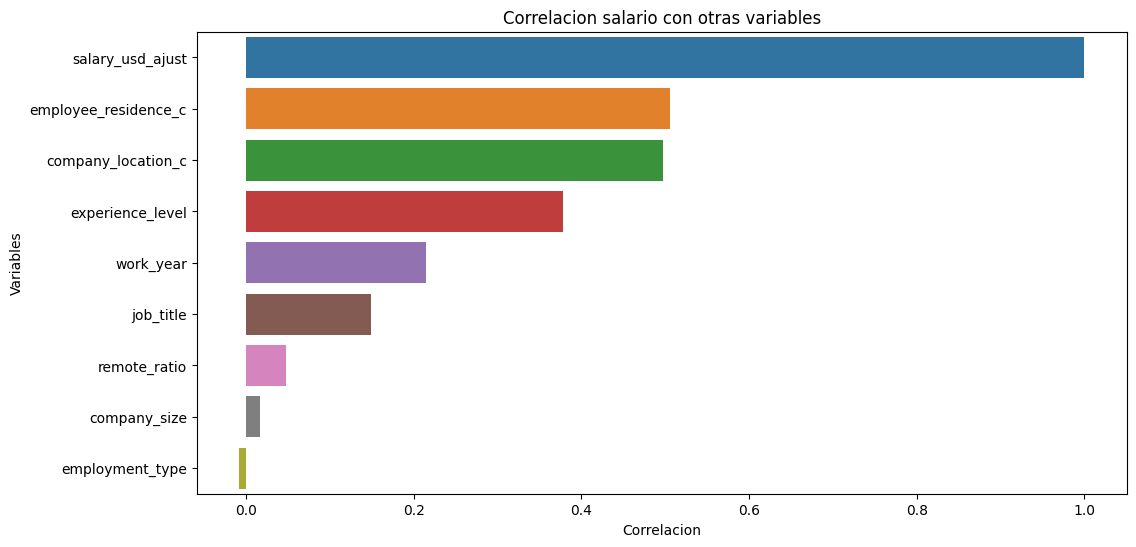

In [152]:
corre_salario_variables = corr_matrix['salary_usd_ajust'].sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=corre_salario_variables.values, y=corre_salario_variables.index, orient='h')
plt.title('Correlacion salario con otras variables')
plt.xlabel('Correlacion')
plt.ylabel('Variables')
plt.show()

## 7 Test Hipotesis

In [153]:

# Obtener los salarios para cada año
salarios_2020 = df[df['work_year'] == 2020]['salary_usd_ajust']
salarios_2021 = df[df['work_year'] == 2021]['salary_usd_ajust']
salarios_2022 = df[df['work_year'] == 2022]['salary_usd_ajust']
salarios_2023 = df[df['work_year'] == 2023]['salary_usd_ajust']

# Realizar las pruebas de hipótesis con la alternativa "less"
result_2020_2021 = mannwhitneyu(salarios_2020, salarios_2021, alternative='less')
result_2021_2022 = mannwhitneyu(salarios_2021, salarios_2022, alternative='less')
result_2022_2023 = mannwhitneyu(salarios_2022, salarios_2023, alternative='less')

# Imprimir los resultados
print("Comparación 2020 vs 2021:")
print("Estadístico U:", result_2020_2021.statistic)
print("Valor p:", result_2020_2021.pvalue)

print("Comparación 2021 vs 2022:")
print("Estadístico U:", result_2021_2022.statistic)
print("Valor p:", result_2021_2022.pvalue)

print("Comparación 2022 vs 2023:")
print("Estadístico U:", result_2022_2023.statistic)
print("Valor p:", result_2022_2023.pvalue)
 

Comparación 2020 vs 2021:
Estadístico U: 8302.0
Valor p: 0.2564770495949391
Comparación 2021 vs 2022:
Estadístico U: 116496.0
Valor p: 2.9775403633058112e-22
Comparación 2022 vs 2023:
Estadístico U: 1276625.5
Valor p: 4.834818775213313e-13


In [154]:
def chequeo_test_variables(df, variable, categoria):

        """
        Esta función realiza pruebas de hipótesis para determinar si los salarios ajustados por inflación para una categoría específica de una variable dada han experimentado un aumento significativo en diferentes años.

        Parámetros:
        - df: DataFrame que contiene los datos para el análisis.
        - variable: Nombre de la variable cuya categoría se analizará.
        - categoria: Categoría específica de la variable para la cual se realizará el análisis.

        Descripción:
        La función toma como entrada un DataFrame "df", el nombre de una variable "variable" y una categoría específica "categoria". Luego, filtra los datos para obtener los salarios ajustados por inflación
        correspondientes a la categoría dada en diferentes años (2020, 2021, 2022 y 2023). A continuación, utiliza la prueba estadística de Mann-Whitney U para comparar los salarios en pares de 
        años consecutivos (2020-2021, 2021-2022 y 2022-2023). 

        La función imprime los resultados de las pruebas de hipótesis para cada par de años, incluyendo el aumento o no del salario ajustado entre los años, y el valor de p-valor asociado a la prueba. 
        Si el p-valor es menor que 0.05 para todos los pares de años, se considera que el salario ajustado ha experimentado un aumento significativo en todos esos años.

        Retorno:
        La función no tiene valor de retorno explícito, ya que su objetivo principal es imprimir los resultados de las pruebas de hipótesis para el análisis.
        """



        print(f"Categoría: {categoria}")
    
        anio1 = 2020
        anio2 = 2021
        anio3 = 2022
        anio4 = 2023
        
        salarios_anio1 = df[(df['work_year'] == anio1) & (df[variable] == categoria)]['salary_usd_ajust']
        salarios_anio2 = df[(df['work_year'] == anio2) & (df[variable] == categoria)]['salary_usd_ajust']
        salarios_anio3 = df[(df['work_year'] == anio3) & (df[variable] == categoria)]['salary_usd_ajust']
        salarios_anio4 = df[(df['work_year'] == anio4) & (df[variable] == categoria)]['salary_usd_ajust']
        
        resultado_1_2 = mannwhitneyu(salarios_anio1, salarios_anio2, alternative='less')
        resultado_2_3 = mannwhitneyu(salarios_anio2, salarios_anio3, alternative='less')
        resultado_3_4 = mannwhitneyu(salarios_anio3, salarios_anio4, alternative='less')
        
        p_value_1_2 = resultado_1_2.pvalue
        p_value_2_3 = resultado_2_3.pvalue
        p_value_3_4 = resultado_3_4.pvalue
        
        if p_value_1_2 < 0.05 and p_value_2_3 < 0.05 and p_value_3_4 < 0.05:
            aumento = "Aumentó"
        else:
            aumento = "No aumentó"
        
        print(f"{anio1} - {anio2}: {aumento} (p-valor: {p_value_1_2:.6f})")
        print(f"{anio2} - {anio3}: {aumento} (p-valor: {p_value_2_3:.6f})")
        print(f"{anio3} - {anio4}: {aumento} (p-valor: {p_value_3_4:.6f})")



In [155]:
#probamos la funcion con company_size, L - employment_type, Full-time y remote_ratio, remote
#graficamente podemos observar que estas categorias de las variables parecian aumentar.

chequeo_test_variables(df, 'company_size', 'L')
chequeo_test_variables(df, 'remote_ratio', 'remote')
chequeo_test_variables(df, 'employment_type', 'Full-time')


Categoría: L
2020 - 2021: No aumentó (p-valor: 0.255499)
2021 - 2022: No aumentó (p-valor: 0.019679)
2022 - 2023: No aumentó (p-valor: 0.220426)
Categoría: remote
2020 - 2021: No aumentó (p-valor: 0.205326)
2021 - 2022: No aumentó (p-valor: 0.000000)
2022 - 2023: No aumentó (p-valor: 0.003616)
Categoría: Full-time
2020 - 2021: No aumentó (p-valor: 0.236720)
2021 - 2022: No aumentó (p-valor: 0.000000)
2022 - 2023: No aumentó (p-valor: 0.000000)


In [156]:
df.to_csv('eda_salarioss.csv', index=False)

